In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import cv2
import random
from scipy.signal import savgol_filter
import sys
sys.path.append("src")
import sindy_utils as sindy
from datetime import datetime
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encode = nn.Sequential(
            # encoder: N, 3, 404, 720
            nn.Conv2d(3, 16, 2), # N, 16, 403, 719
            nn.ReLU(),
            nn.Conv2d(16, 32, 2), # N, 32, 402, 718
            nn.ReLU(),
            nn.MaxPool2d((2,3), stride=(2,3)), # N, 32, 201, 239              -- pool --
            nn.Conv2d(32, 64, 4), # N, 64, 198, 236
            nn.ReLU(),
            nn.Conv2d(64, 96, 4), # N, 96, 195, 233
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # N, 96, 97, 116                       -- pool --
            nn.Conv2d(96, 128, 5), # N, 128, 93, 112
            nn.ReLU(),
            nn.Conv2d(128, 150, 5, stride=2, padding=1), # N, 150, 46, 55
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2), # N, 150, 23, 27                        -- pool --
            nn.Conv2d(150, 200, 9, stride=2), # N, 200, 8, 10
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(200*8*10,gl_zDim)
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    
        
        # note: encoder and decoder are not symmetric
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(200, 150, 4), # N, 150, 11, 13
            nn.ReLU(),
            nn.ConvTranspose2d(150, 128, 5, stride=(2,3), padding=(2,2), output_padding=(0,2)), # N, 128, 21, 39
            nn.ReLU(),
            nn.ConvTranspose2d(128, 96, 4, stride=2, padding=(1,0)), # N, 96, 42, 80
            nn.ReLU(),
            nn.ConvTranspose2d(96, 64, 8), # N, 64, 49, 87
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=(2,1), output_padding=(0,1)), # N, 32, 100, 179
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), # N, 16, 201, 359
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)), # N, 3, 404, 720
            nn.ReLU()
        )   
        
        self.fc2 = nn.Linear(gl_zDim, 200*8*10)

    def forward(self, x, z, mode):
        '''
        x: input for encoder
        z: input for decoder
        mode: 
            'train' -> use encoded for decoder
            'test'  -> feed z in an get decoded
        
        '''
        if mode == 'train':
            encoded = self.encode(x)
            encoded = encoded.view(-1,200*8*10)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        else:
            encoded = torch.zeros(1)

            decoded = self.fc2(z)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        
        return encoded, decoded

    
def calculateSindy(z, Xi, poly_order, include_sine_param):
    z_new = z.detach().numpy()
    
    theta = torch.from_numpy(sindy.sindy_library(z_new, poly_order, include_sine=include_sine_param))
    
    dz_prediction = torch.matmul(theta, Xi).float()
    
    return dz_prediction

# use more than 16 frames to get Xi
def constructXi(data, zDim):
    '''
    input: data as a list with shape [len batch_size RGB hight width]
    return: Xi
    
    '''
    # processs the data
    z_tensor = torch.empty((0, zDim))
    data_len = len(data)
    for i in range(data_len):
        if i == 20:
            break
        z_tensor_tmp, _ = autoencoder(train_data[i], 0, mode='train')
        z_tensor = torch.cat((z_tensor, z_tensor_tmp), 0)
        if i % 5 == 0:
            print(i, z_tensor.shape)
        del z_tensor_tmp

    print(z_tensor.shape)
    
    dz_tensor = z_tensor[2:data_len]
    z_tensor = z_tensor[1:data_len-1]
    
    # calculate sindy and Xi for the data
    z = z_tensor.cpu().detach().numpy()
    dz = dz_tensor.cpu().detach().numpy()

    Theta = torch.from_numpy(sindy.sindy_library(z, gl_poly_order, include_sine=gl_include_sine_param))
    Xi = torch.from_numpy(sindy.sindy_fit(Theta, dz, gl_threshold_sindy))
    
    return Xi

def matrixToNorm(x, offset=0, factor=0.95):
    x = (x - x.min() + offset) / x.max() * factor
    return x


2022-01-22 17:04:02


In [5]:
############################## configurations #####################################
gl_epoch = 3000
gl_zDim = 3
gl_poly_order = 5
gl_lr_rate = 1e-05
gl_include_sine_param = False
gl_threshold_sindy = 0.1
gl_batchSize = 16

path_folder = 'results/v5_3_z'+str(gl_zDim)+'_translation/'
path_figures = 'figures/v5_3_z'+str(gl_zDim)+'_translation/'


### Loading the data and the model

In [3]:
# loading model
to_load = path_folder+'Ae_'+str(gl_epoch)+'epoch_bs16_lr'+str(gl_lr_rate)+'_z'+str(gl_zDim)+'_sindt'+str(gl_threshold_sindy)+'_poly'+str(gl_poly_order)+'PFrame.pt'
autoencoder = torch.load(to_load)
autoencoder = autoencoder.cpu()

# load a train data
path_folder_data = path_folder+'data/'
train_data = torch.load(path_folder_data + 'train_data.pt')
print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))
print('train data reading done!')

# load a validation data
validation_data = torch.load(path_folder_data + 'validation_data.pt')
print('validation data: ', len(validation_data), len(validation_data[0]), len(validation_data[0][0]), len(validation_data[0][0][0]), len(validation_data[0][0][0][0]))
print('validation data reading done!')

# loading test data
test_data = torch.load(path_folder_data + 'test_data.pt')
print('test data: ', len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]), len(test_data[0][0][0][0]))
print('test data reading done!')

# load Xi
Xi = torch.load(path_folder + 'Xi_'+str(gl_epoch)+'epoch_bs16_lr'+str(gl_lr_rate)+'_z'+str(gl_zDim)+'_sindt'+str(gl_threshold_sindy)+'_poly'+str(gl_poly_order)+'PFrame.pt')
print('Xi loaded succesfully!')
print(Xi)

train data:  160 16 3 404 720
train data reading done!
validation data:  22 16 3 404 720
validation data reading done!
test data:  20 16 3 404 720
test data reading done!
Xi loaded succesfully!
tensor([[0.0000, 0.0000, 0.0000],
        [0.9971, 0.0000, 0.0000],
        [0.0000, 0.9949, 0.0000],
        [0.0000, 0.0000, 0.9948],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000,

### plotting images of autoencoder

random picture from train_data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

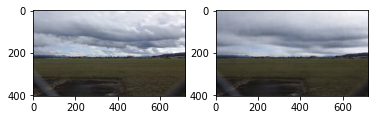

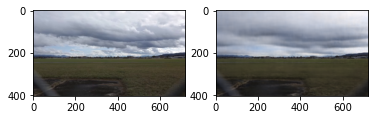

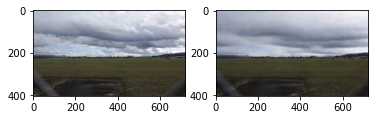

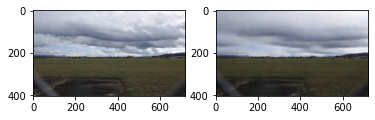

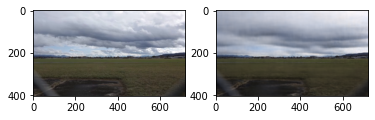

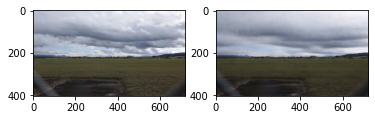

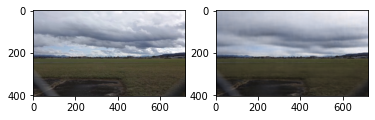

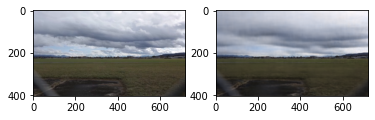

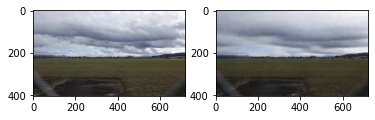

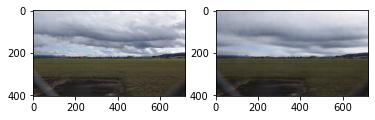

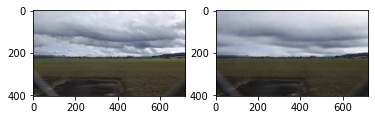

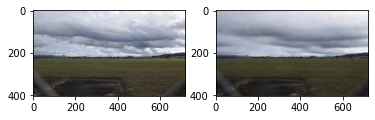

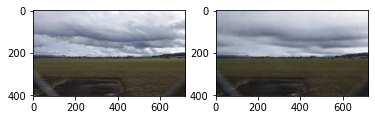

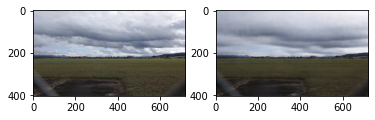

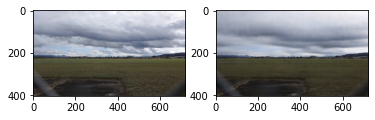

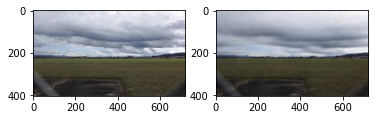

In [4]:
whichData = 'train_data'
if whichData == 'train_data':
    data = train_data
elif whichData == 'validation_data':
    data = validation_data
elif whichData == 'test_data':
    data = test_data

    
# plot random auto encoder result
plt.show()
print('random picture from '+str(whichData))
randPlace = random.randint(0, len(data)-1)
z_tensor, recon_tensor = autoencoder(data[randPlace], 0, mode='train')
# plot sindy result
for nbImag in range(len(recon_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(data[randPlace][nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon_tensor[nbImag].permute(1,2,0).detach().numpy())
plt.savefig(path_figures+'autoencoder_'+str(whichData)+'_'+str(gl_epoch)+'epoch_PFrame.png')
plt.show()


### plotting images for the first glance of prediction

prediction at step 0


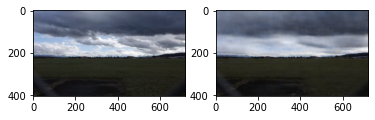

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction at step 1


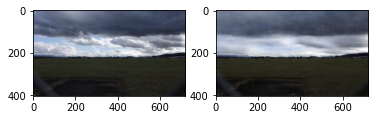

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction at step 2


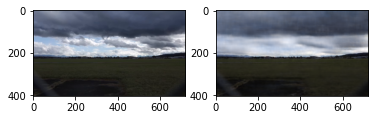

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction at step 3


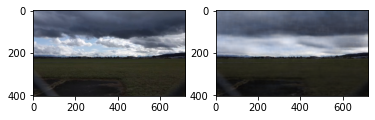

prediction at step 4


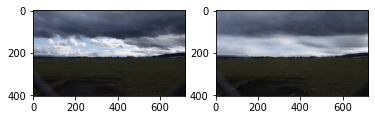

prediction at step 5


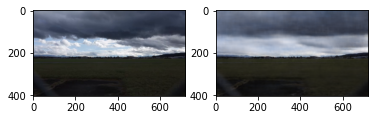

prediction at step 6


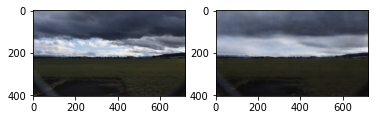

prediction at step 7


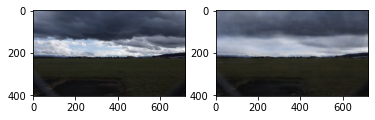

prediction at step 8


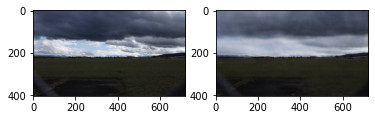

prediction at step 9


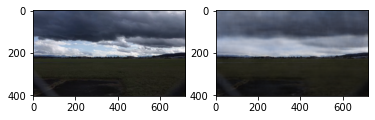

prediction at step 10


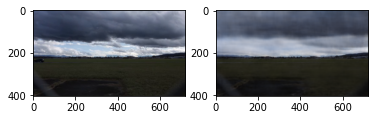

prediction at step 11


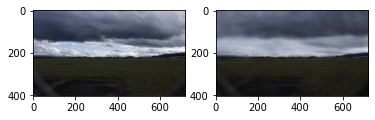

prediction at step 12


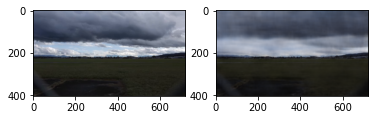

prediction at step 13


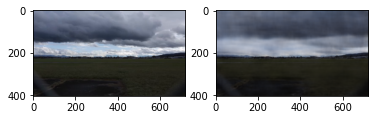

prediction at step 14


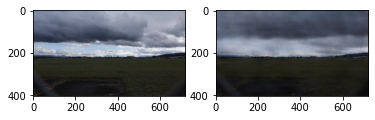

In [9]:
whichData = 'train_data'
if whichData == 'train_data':
    data = train_data
elif whichData == 'validation_data':
    data = validation_data
elif whichData == 'test_data':
    data = test_data

    
z_tensor, recon_tensor = autoencoder(data[0], 0, mode='train')
z = z_tensor.cpu()
nbrSteps = 15                 # number of steps, validation_data: len(data) 
for step in range(nbrSteps):
    print('prediction at step', step)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(data[step][0].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon_tensor[0].permute(1,2,0).detach().numpy())
    # SINDy prediction
    z_last = z[len(z)-1]
    dz_predict = torch.empty((0, gl_zDim))
    for i in range(gl_batchSize):
        Theta = torch.from_numpy(sindy.sindy_library(z_last.cpu().detach().numpy().reshape((1,gl_zDim)), gl_poly_order, include_sine=gl_include_sine_param))
        z_last = torch.matmul(Theta, Xi).float().cpu()
        dz_predict = torch.cat((dz_predict, z_last.cpu()))
    _, recon_tensor = autoencoder(0, dz_predict, mode='test')
    z = dz_predict.cpu()
    # that savefig works
    if step != nbrSteps-1:
        plt.show()

plt.savefig(path_figures+'prediction'+str(nbrSteps)+'Steps_'+str(whichData)+'_'+str(gl_epoch)+'epoch_PFrame.png')
plt.show()


### plotting in z dimension

0
5
10
15
20
25
30
35
40
45
z_true dimension (800, 3)


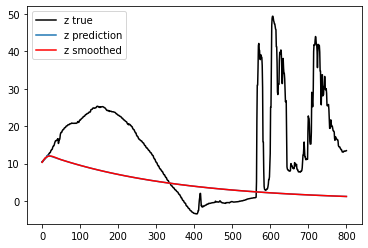

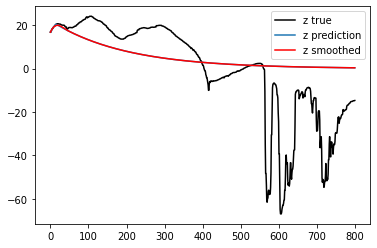

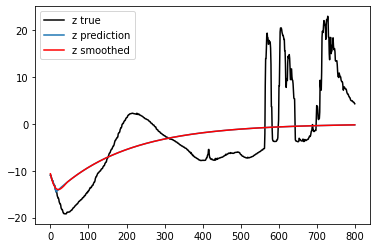

In [11]:
whichData = 'train_data'
if whichData == 'train_data':
    data = train_data
elif whichData == 'validation_data':
    data = validation_data
elif whichData == 'test_data':
    data = test_data
    
ChooseLength = 50  # len(data)
batch_size = 16

# compute true z
z_true = np.empty((ChooseLength*batch_size, gl_zDim))
for index in range(0, ChooseLength):
    if index >= len(data):
        break
    z_tensor, recon_tensor = autoencoder(data[index], 0, mode='train')
    z_true[index*batch_size:(index+1)*batch_size][:] = z_tensor.cpu().detach().numpy()
    if index % 5 == 0: print(index)

print('z_true dimension', z_true.shape)
    
# print graph(s) for z_true
for graph in range(z_true.shape[1]):
    plt.figure(graph)
    x = np.linspace(0, z_true.shape[0], z_true.shape[0])
    y = z_true[:,graph]
    plt.plot(x, y, color='black', label='z true')

# compute sindy z predition based on first one
z_tensor, recon_tensor = autoencoder(data[0], 0, mode='train')
z = z_tensor.cpu()
z_sindy = np.empty((ChooseLength*batch_size, gl_zDim))
z_sindyUnsmooth = np.empty((ChooseLength*batch_size, gl_zDim))
z_sindy[0:16] = z.cpu().detach().numpy()
for index_s in range(0, ChooseLength-1):
    # SINDy prediction
    z_last = z[len(z)-1]
    dz_predict = torch.empty((0, gl_zDim))
    for i in range(gl_batchSize):
        Theta = torch.from_numpy(sindy.sindy_library(z_last.cpu().detach().numpy().reshape((1,gl_zDim)), gl_poly_order, include_sine=gl_include_sine_param))
        z_last = torch.matmul(Theta, Xi).float().cpu()
        dz_predict = torch.cat((dz_predict, z_last.cpu()))
    _, recon_tensor = autoencoder(0, dz_predict, mode='test')
    z = dz_predict.cpu()
    z_sindy[(index_s+1)*batch_size:(index_s+2)*batch_size] = dz_predict.cpu().detach().numpy()
        
# print graph(s) for z_sindy
for graph in range(z_sindy.shape[1]):
    plt.figure(graph)
    x = np.linspace(0, z_sindy.shape[0], z_sindy.shape[0])
    y = z_sindy[:,graph]
    z_sindyUnsmooth[:,graph] = z_sindy[:,graph]              # save unsmoothed signal for later use
    plt.plot(x, y, label='z prediction')
    # smooth z coordinate plot
    z_sindy[:,graph] = savgol_filter(z_sindy[:,graph], 61, 3)
    y = z_sindy[:,graph]
    plt.plot(x, y, color='red', label='z smoothed')
    plt.legend()
    plt.savefig(path_figures+'graph_z'+str(graph)+'_'+str(whichData)+'_length'+str(ChooseLength)+'_'+str(gl_epoch)+'epoch_PFrame.png')

plt.show()

del z_true


### Producing a video with sindy steps

In [12]:
# test with z_sindy from above
batch_size = 16

# test model with filtered z coordinates
def test(zData):
    video_reconstruction = []
    # predict videos
    for i in range(int(len(zData)/batch_size)):
        print(i)
        z_tensor = torch.from_numpy(zData[i*batch_size:(i+1)*batch_size,:])
        _, recon_tensor = autoencoder(0, z_tensor.float(), mode='test')
        video_reconstruction.append(recon_tensor)        
            
    return video_reconstruction


video_output = test(z_sindy)
print('prediction done!')

#del test_data

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
prediction done!


In [ ]:
# test with raw data
whichData = 'train_data'
if whichData == 'train_data':
    data = train_data
elif whichData == 'validation_data':
    data = validation_data
elif whichData == 'test_data':
    data = test_data
    
until = 15

# test model from data
def test(data):
    video_reconstruction = []
    # predict videos
    # first step encode first batch
    img = data[0]
    z_tensor, recon_tensor = autoencoder(img, 0, mode='train')
    
    # predict the future using only sindy model, new video starts always at position vid_nbr * until
    for i in range(0, until):
        if i % 5 == 0: print('pred', i)
        video_reconstruction.append(recon_tensor)
        dz_tensor = calculateSindy(z_tensor, Xi, gl_poly_order, gl_include_sine_param)
        _, recon_tensor = autoencoder(0, dz_tensor, mode='test')
        z_tensor = dz_tensor
            
    return video_reconstruction


video_output = test(test_data)
print('prediction done!')

#del test_data

In [15]:
# make videos
frame_width = len(video_output[0][0][0][0])
frame_height = len(video_output[0][0][0])
fps = 25.0
video_output = video_output
#fourcc = cv2.VideoWriter_fourcc('I','4','2','0')
#fourcc = cv2.VideoWriter_fourcc('P','I','M','1')
#fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
fourcc = cv2.VideoWriter_fourcc('D','I','V','3')
#fourcc = cv2.VideoWriter_fourcc('F','L','V','1')
# write different videos
#fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
#fourcc = cv2.VideoWriter_fourcc('D','I','V','3')
#fourcc = cv2.VideoWriter_fourcc('F','M','P','4')
out1 = cv2.VideoWriter(path_figures+'prediction_smoothed_train_data_3500epoch_PFrame.avi', fourcc, fps, (frame_width,frame_height))
#out2 = cv2.VideoWriter('video2.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))


print('output video', len(video_output), len(video_output[0]), len(video_output[0][0]), len(video_output[0][0][0]), len(video_output[0][0][0][0]))

# undo batch structure
videoProcessing = []
count = -1
for img in range(0, len(video_output)*len(video_output[0])):
    imgIn_batch = img % batch_size
    # new batch
    if imgIn_batch == 0:
        count += 1
    img_toAppend = video_output[count][imgIn_batch]
    videoProcessing.append(img_toAppend)
        
#del video_output
print('video currently procession', len(videoProcessing), len(videoProcessing[0]), len(videoProcessing[0][0]), len(videoProcessing[0][0][0]))
    
for img in range(0,len(videoProcessing)):
    frame_local = np.transpose(videoProcessing[img].detach().numpy(), [1,2,0])
    frame_local = cv2.cvtColor(frame_local, cv2.COLOR_RGB2BGR)
    # print(frame_local) --> seems unstable, not a number and doesn't save it as a video
    out1.write(frame_local.shape)
    # show video
    cv2.imshow('Frame',frame_local)
    
    # wait at the beginning
    if img == 0:
        print('stopped video in frame',img)
        while(True):
            if cv2.waitKey(25) & 0xFF == ord('e'):
                break

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q') and img >= 10:
        break
    
    # Press w on keyboard to wait
    if cv2.waitKey(25) & 0xFF == ord('w'):
        print('stopped video in frame', img)
        while(True):
            if cv2.waitKey(25) & 0xFF == ord('e'):
                break
            

# When everything done, release the video capture and video write objects
out1.release()

# Closes all the frames
cv2.destroyAllWindows()

print('finished prediction video output!')

output video 50 16 3 404 720
video currently procession 800 3 404 720
stopped video in frame 0
finished prediction video output!


#### some more things

In [ ]:
Xi = constructXi(train_data, gl_zDim)